---
title: Sinusoidal Model Fitting
---

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Annual Sunspots Dataset

The following dataset is downloaded from https://www.sidc.be/SILSO/datafiles (silso stands for sunspot index and long term solar observations). Data description can be found here: https://www.sidc.be/SILSO/infosnytot. There are five columns:

1. Column 1 is the year (2020.5 refers to the year 2020 for example)
2. Column 2 is the yearly mean total sunspot number (this is obtained by taking a simple arithmetic mean of the daily sunspot number over all the days for that year)
3. Column 3 is the yearly mean standard deviation of the input sunspot numbers from individual stations (-1 indicates missing value)
4. Column 4 is the number of observations used to compute the yearly mean sunspot number (-1 indicates a missing value)
5. Column 5 is a definitive/provisional marker (1 indicates that the data point is definitive, and 0 indicates that it is still provisional)

We shall work with the data in column 2 (yearly mean total sunspot number). 

In [150]:
#annual sunspots dataset:
sunspots = pd.read_csv('SN_y_tot_V2.0.csv', header = None, sep = ';')
print(sunspots.head())
sunspots.columns = ['year', 'sunspotsmean', 'sunspotssd', 'sunspotsnobs', 'isdefinitive']
print(sunspots.head(10))

        0     1    2  3  4
0  1700.5   8.3 -1.0 -1  1
1  1701.5  18.3 -1.0 -1  1
2  1702.5  26.7 -1.0 -1  1
3  1703.5  38.3 -1.0 -1  1
4  1704.5  60.0 -1.0 -1  1
     year  sunspotsmean  sunspotssd  sunspotsnobs  isdefinitive
0  1700.5           8.3        -1.0            -1             1
1  1701.5          18.3        -1.0            -1             1
2  1702.5          26.7        -1.0            -1             1
3  1703.5          38.3        -1.0            -1             1
4  1704.5          60.0        -1.0            -1             1
5  1705.5          96.7        -1.0            -1             1
6  1706.5          48.3        -1.0            -1             1
7  1707.5          33.3        -1.0            -1             1
8  1708.5          16.7        -1.0            -1             1
9  1709.5          13.3        -1.0            -1             1


0     8.3
1    18.3
2    26.7
3    38.3
4    60.0
Name: sunspotsmean, dtype: float64


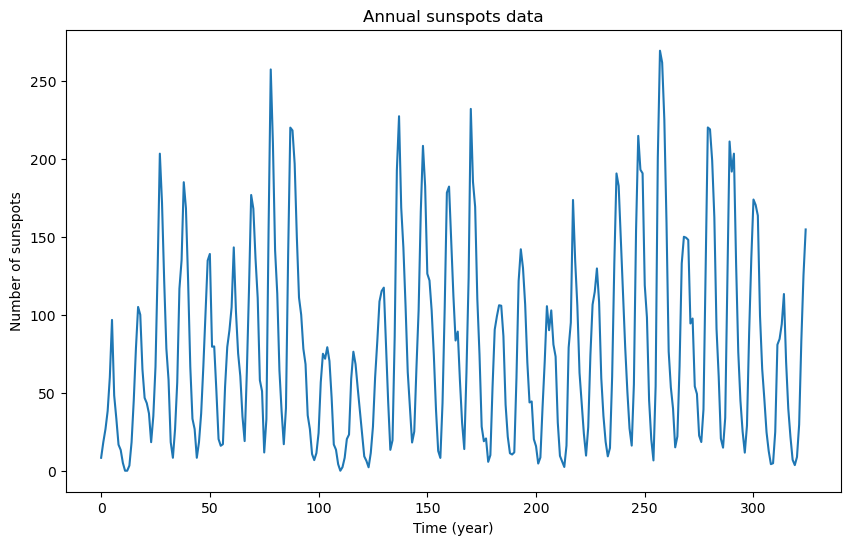

In [151]:
y = sunspots['sunspotsmean']
print(y.head())
plt.figure(figsize = (10, 6))
plt.plot(y)
plt.xlabel('Time (year)')
plt.ylabel('Number of sunspots')
plt.title('Annual sunspots data')
plt.show()

We will fit the sinusoidal model: 
\begin{equation*}
  y_t = \beta_0 + \beta_1 \cos(2 \pi f t) + \beta_2 \sin(2 \pi f t) + \epsilon_t
\end{equation*}
with $\epsilon_t$ being i.i.d $N(0, \sigma^2)$. When $f$ is known, this is a linear regression model. We can fit this model to the data and see how good the fit is while varying $f$. This will give us an idea of which frequencies give good fits to the data. Later we shall consider $f$ as an unknown parameter and discuss estimation and inference for $f$. 

                            OLS Regression Results                            
Dep. Variable:           sunspotsmean   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.116
Date:                Tue, 04 Feb 2025   Prob (F-statistic):              0.329
Time:                        22:55:55   Log-Likelihood:                -1800.7
No. Observations:                 325   AIC:                             3607.
Df Residuals:                     322   BIC:                             3619.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.8250      3.437     22.937      0.0

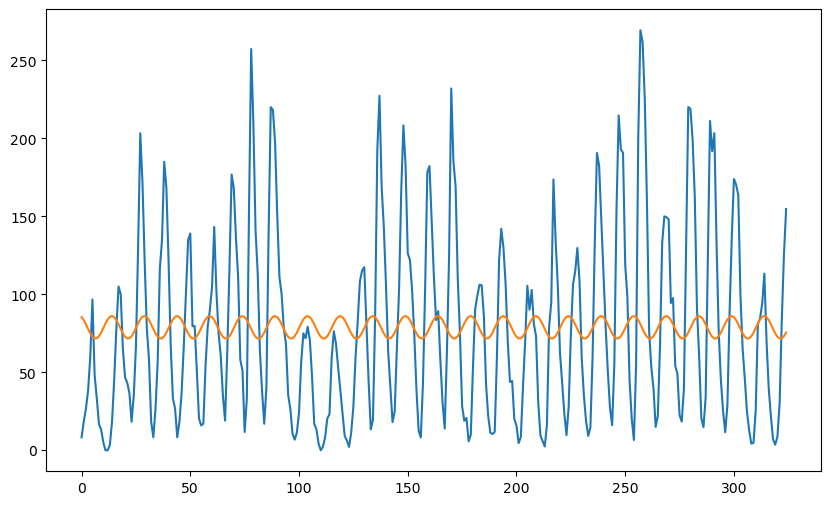

In [152]:
#Let us try some frequencies to get  intuition:
n = len(y)
x = np.arange(1, n+1)
f = 1/10
f = 1/11 #wikipedia article on sunspots states that the sunspots periodicity is 11
f = 1/4
f = 1/15
sinvals = np.sin(2 * np.pi * f * x)
cosvals = np.cos(2 * np.pi * f * x)
X = np.column_stack([np.ones(n), sinvals, cosvals])
md = sm.OLS(y, X).fit()
print(md.summary())

plt.figure(figsize = (10, 6))
plt.plot(y)
plt.plot(md.fittedvalues)


Now we treat $f$ also as an unknown parameter. The MLE of $f$ can be found as follows. Define: 
\begin{equation*}
   \text{crit}(f) := \min_{\beta_0, \beta_1, \beta_2} \sum_{t=1}^n \left( y_t - \beta_0 - \beta_1 \cos(2 \pi f t) - \beta_2 \sin(2 \pi f t) \right)^2
\end{equation*}
and then minimize $\text{crit}(f)$ over all $f$ to obtain $\hat{f}$.

In [153]:
def crit(f):
    x = np.arange(1, n+1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    return rss

Evaluate $\text{crit}(f)$ at some standard values of $f$ to get a feel for which frequencies fit the data well. 

In [154]:
print(crit(1/11))
print(crit(1/10.8))

866129.2421378705
1115830.3682578618


Now we proceed to minimization of $\text{crit}(f)$ over $f$. We take a grid of values in the range $[0, 0.5]$ and do a numerical minimization over the grid. 

In [155]:
gridres = 0.00001
allfvals = np.arange(0, 0.5, gridres)
critvals = np.array([crit(f) for f in allfvals])
#if this code is taking too long, you can increase gridres slightly

The MLE is approximated by the minimizer of $\text{crit}(f)$ over the grid values. 

In [157]:
fhatmle = allfvals[np.argmin(critvals)]
print(fhatmle)


0.09089000000000001


The MLE of the period equals the reciprocal of $\hat{f}$: 

In [158]:
print(1/fhatmle)

11.00231048520189


The MLE of $f$ is 11.0023.

Here is a plot of $\text{crit}(f)$ over $f$. 

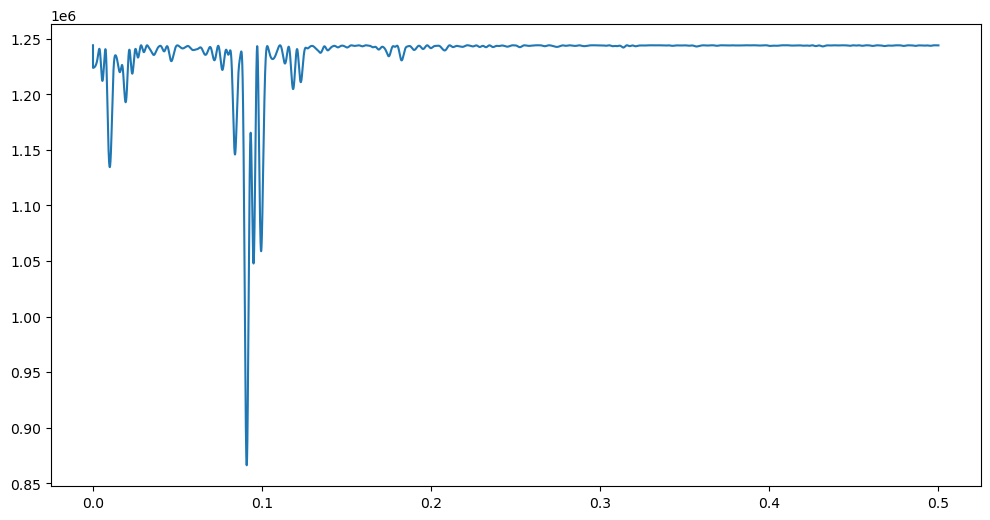

In [83]:
plt.figure(figsize = (12, 6))
plt.plot(allfvals, critvals)

While there is a single clear minimizer of $\text{crit}(f)$, there seem to be many smaller local minima. Also the plot is overall quite nonsmooth. The function $\text{crit}(f)$ is quite closely related to the **periodogram** as we shall see in the next class. The periodogram is a standard time series data analysis tool. 

Next we perform Bayesian inference. We compute the posterior density that was derived in class (numerically over the grid). For this grid, we exclude the boundary values $0$ and $0.5$ because the determinant term equals infinite at these frequencies. 

In [162]:
gridres = 0.00001
allfvals = np.arange(0.001, 0.499, gridres)

The function for calcualating the posterior density is given below. Instead of calculating the posterior directly, we first calculate its logarithm because of numerical reasons. 

In [163]:
def logpost(f):
    x = np.arange(1, n+1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])
    p = X.shape[1]
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) #sgn gives the sign of the determinant (in our case, this should 1)
    #log_det gives the logarithm of the absolute value of the determinant
    logval = ((p-n)/2) * np.log(rss) - (0.5)*log_det
    return logval

In [164]:
logpostvals = np.array([logpost(f) for f in allfvals])

Now we exponentiate the log-posterior values to get the posterior values. We first substract a constant value to make sure there are no large positive log-values before exponentiating them. 

In [165]:
postvals = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals/(np.sum(postvals))

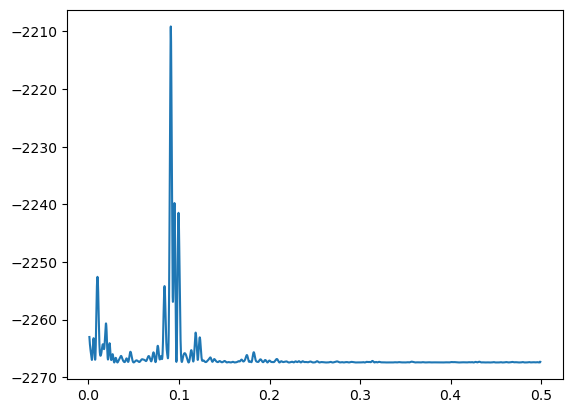

In [103]:
plt.plot(allfvals, logpostvals)

The above plot looks similar to the plot of $\text{crit}(f)$ (except it is upside down). The maximizer of the posterior density is exactly the same as the MLE. 

In [167]:
print(allfvals[np.argmax(postvals)])
print(1/allfvals[np.argmax(postvals)])


0.09089000000000023
11.002310485201864


Let us now provide a credible 95\% interval for $f$. This is an interval for which the posterior probability is more than 0.95. We can do this as follows. The following function takes an input value $m$ and compute the posterior probability assigned to the interval $\hat{f} - m*\delta, \hat{f} + m*\delta$ where $\delta$ is the grid resolution that we used for computing the posterior. 

In [168]:
def PostProbAroundMax(m):
    est_ind = np.argmax(postvals)
    ans = np.sum(postvals[(est_ind-m):(est_ind+m)])
    return(ans)

We now start with a small value of $m$ (say $m = 0$) and keep increasing it until the posterior probability reaches 0.95. 

In [169]:
print(PostProbAroundMax(0))
print(PostProbAroundMax(1))
print(PostProbAroundMax(10))
print(PostProbAroundMax(20))
print(PostProbAroundMax(25))
print(PostProbAroundMax(28))


0.0
0.05687412633667126
0.5238894157501024
0.8444084186344701
0.9233279638904347
0.9521883889485292


So the posterior probability reaches 0.95 at $m = 28$. This lets us compute the credible interval for $f$ in the following way. 

In [101]:
est_ind = np.argmax(postvals)
f_est = allfvals[est_ind]
#95% credible interval for f:
ci_f_low = allfvals[est_ind - 28]
ci_f_high = allfvals[est_ind + 28]
print(np.array([f_est, ci_f_low, ci_f_high]))

[0.09089 0.09061 0.09117]


This interval can be inverted to compute the credible interval for the period $1/f$:

In [102]:
#For the period (1/frequency)
print(np.array([1/f_est, 1/ci_f_high, 1/ci_f_low]))

[11.00231049 10.96852035 11.03630946]
